#### Machine Learning Group Homework 4: K-Means Clustering 

##### 1. Explore the website http://sofifa.com.

press 'All' tab, then https://sofifa.com/players?offset=0 (page1) https://sofifa.com/players?offset=80 (page2) : Page  
press 'flag' then https://sofifa.com/players?na=52 (Argentinia) https://sofifa.com/players?na=14 (England) : Nation Code  
press 'next'tab in the bottoom  https://sofifa.com/players?na=52&offset=80  : Nation code + page  
press an individual player https://sofifa.com/player/142959 (each players' id for the attributes)  

###### Import Modules

In [1]:
# scrape data
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import unicodedata

# machine learning
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

##### 2. Explain in detail the code below. 

To extract the each players' attributes, we need to get the players number id (eg: "https://sofifa.com/player/142959") . 
 
1. The `requests.get()` function creates a request object for each page  
 
2. Each page's content (html tag and content) is downloaded and parsed by the `BeautifulSoup()` function with the argument `html.parser`  
 
3. The `find_all()` function of the BeautifulSoup object is used to get the all the links on the page, referenced by the html `a` tag.  
 
4. The `href` tag is used to locate and extract the hyperlinks for all links on the page
 
5. The links variable (`for j,link in enumerate(links)`) stores links for each player's attributes page, ie: "https://sofifa.com/player/142959"  

In [2]:
attributes=['Crossing','Finishing','Heading accuracy',
 'Short passing','Volleys','Dribbling','Curve',
 'Free kick accuracy','Long passing','Ball control','Acceleration',
 'Sprint speed','Agility','Reactions','Balance',
 'Shot power','Jumping','Stamina','Strength',
 'Long shots','Aggression','Interceptions','Positioning',
 'Vision','Penalties','Composure','Marking',
 'Standing tackle','Sliding tackle','GK diving',
 'GK handling','GK kicking','GK positioning','GK reflexes']

In [3]:
links=[]   #get all argentinian players
for offset in ['0','80','160','240','320','400','480','560']:
    page=requests.get('http://sofifa.com/players?na=52&offset='+offset) 
    # request page information from server
    soup=BeautifulSoup(page.content,'html.parser')
    # stores the content of the page's html
    for link in soup.find_all('a'):
        # find all html link tags (a)
        links.append(link.get('href'))
        # get all hyperlink references
links=['http://sofifa.com'+l for l in links if 'player/'in l]  
# if the link contains /player, indicates that it is a link to a player's page, where the player's id is in the url 
# appends the first part of the url to the second part containing player's id

In [4]:
#pattern regular expression 
pattern=r"""\s*([\w\s]*?)\s*FIFA"""   #file starts with empty spaces... players name...FIFA...other stuff     
# the regular expression looks for each player's name and only grabs text that matches the pattern
for attr in attributes:
    pattern+=r""".*?(\d*\s*"""+attr+r""")"""  #for each attribute we have other stuff..number..attribute..other stuff
pat=re.compile(pattern, re.DOTALL)    #parsing multiline text

In [5]:
rows=[]
links=links[10:]

for j, link in enumerate(links):
# for j,link in enumerate(links):
#     print j,link
    # start building a list of attributes for each player
    # each player has its own row of attributes
    row=[link]
    playerpage=requests.get(link)
    # request page information from server
    playersoup=BeautifulSoup(playerpage.content,'html.parser')
    # stores content of page's html
    text=playersoup.get_text()
    # get text without html tags
    text=unicodedata.normalize('NFKD', text).encode('ascii','ignore') #unicode NFKD normalization
    a=pat.match(text.decode('utf-8')) #decode according to utf-8 standard
    row.append(a.group(1))
    # appends the players name to the row of player data

    for i in range(2,len(attributes)+2):
        row.append(int(a.group(i).split()[0]))
        # append each of the player's attributes defined above to the row of player data

    rows.append(row)
    # appends the row containing all the player's data to a list containing all rows of player data

In [6]:
df=pd.DataFrame(rows,columns=['link','name']+attributes)
# convert list of rows to dataframe
df.to_csv('ArgentinaPlayers.csv',index=False)
# export to csv

##### 3. Change the code to download the first 480 English players instead.

In order to scrape data for English players, the part of the URL that points to the English player needs to be changed. In the above code, `na=54` corresponds to the code for Argentinian players. This part of the url needs to be changed to `na=14`. 
To scrape the first 480 players, the offset needs to be modified as well. Each page lists 80 players, thus the offset needs to range from 0 to 400, by increments of 80.

In [5]:
links=[]
for offset in ['0','80','160','240','320','400']:
    page=requests.get('http://sofifa.com/players?na=14&offset='+offset) 
    soup=BeautifulSoup(page.content,'html.parser')
    for link in soup.find_all('a'):
        links.append(link.get('href'))
links=['http://sofifa.com'+l for l in links if 'player/'in l]  

In [6]:
pattern=r"""\s*([\w\s]*?|[\w\-\w\s]*?|[\w\'\w\s]*?)\s*FIFA"""    #file starts with empty spaces... players name...FIFA...other stuff     
for attr in attributes:
    pattern+=r""".*?(\d*\s*"""+attr+r""")"""  #for each attribute we have other stuff..number..attribute..other stuff
pat=re.compile(pattern, re.DOTALL)    #parsing multiline text

In [7]:
rows=[]
links=links[10:]

for j, link in enumerate(links):
    row=[link]
    playerpage=requests.get(link)
    playersoup=BeautifulSoup(playerpage.content,'html.parser')
    text=playersoup.get_text()
    text=unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    a=pat.match(text.decode('utf-8'))
    row.append(a.group(1))

    for i in range(2,len(attributes)+2):
        row.append(int(a.group(i).split()[0]))

    rows.append(row)

In [8]:
print("Number of players is : {}".format(len(rows)))

Number of players is : 470


In [9]:
df=pd.DataFrame(rows,columns=['link','name']+attributes)
# convert list of rows to dataframe
df.to_csv('EnglandPlayers.csv',index=False)
# export to csv

##### 4. Use the sklearn.cluster.KMeans Python class to cluster the players into 4 clusters. 

In [10]:
# Prepare data
X = df.iloc[:,2:].values * 1.0 # multiply by 1.0 to transform "int" to "float"
X

array([[ 11.,  16.,  12., ...,  72.,  78.,  85.],
       [ 77.,  81.,  75., ...,  13.,   8.,   7.],
       [ 86.,  63.,  74., ...,  10.,  13.,  12.],
       ..., 
       [ 31.,  65.,  65., ...,  13.,   8.,   9.],
       [ 60.,  51.,  38., ...,   7.,  10.,  13.],
       [ 53.,  57.,  38., ...,   8.,   9.,   9.]])

In [11]:
# Scale transformation
sdscaler = StandardScaler()
X_scale = sdscaler.fit_transform(X)

In [12]:
# Kmeans model
kmeans = KMeans(n_clusters=4)
predict_label = kmeans.fit_predict(X_scale)
predict_label

array([2, 1, 0, 0, 0, 0, 3, 1, 2, 0, 0, 1, 1, 0, 1, 0, 3, 0, 2, 0, 1, 0, 2,
       3, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 3, 3, 0, 1, 1, 0, 0, 1,
       2, 3, 3, 0, 1, 1, 0, 0, 3, 0, 1, 3, 1, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 1, 1, 0, 3, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 1, 3, 0, 1, 0, 3, 0, 3, 2, 2, 0,
       2, 1, 1, 0, 1, 3, 0, 3, 0, 0, 1, 1, 1, 2, 0, 0, 3, 2, 0, 2, 3, 0, 0,
       1, 1, 0, 2, 1, 0, 1, 1, 0, 3, 0, 0, 0, 3, 0, 3, 1, 2, 1, 1, 3, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 3, 1, 3, 0, 1, 3, 2, 1, 3, 3, 2, 3, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 3, 3, 0, 3, 1, 3, 0, 3, 3, 1, 0, 0, 1, 1, 0, 0, 1, 3,
       1, 0, 1, 0, 3, 1, 3, 3, 0, 2, 3, 3, 3, 0, 1, 1, 3, 1, 1, 2, 0, 3, 3,
       1, 2, 1, 1, 0, 1, 0, 3, 0, 0, 2, 0, 0, 1, 1, 0, 3, 0, 0, 0, 0, 1, 3,
       1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 1, 3, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0,
       1, 3, 0, 1, 0, 0, 1, 2, 1, 3, 0, 1, 3, 0, 3, 0, 2, 0, 1, 0, 3, 0, 3,
       3, 3,

###### Visualization

In [13]:
# reduce the data to 2-dimension using t-SNE
tsne= TSNE(learning_rate=50)
data_for_visualization = tsne.fit_transform(X_scale)

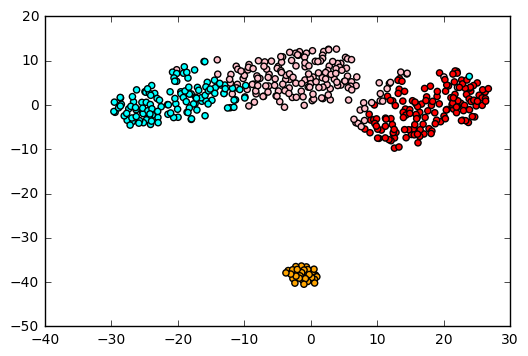

In [16]:
predictions = pd.DataFrame(predict_label, columns = ['label'])
color_dict = {0:'red', 1:'cyan', 2:'pink', 3:'orange'}
color = predictions.replace({'label': {0:'red', 1:'cyan', 2:'pink', 3:'orange'}})
color = list(color['label'])
plt.scatter(data_for_visualization[:,0], data_for_visualization[:,1], c=color)
plt.show()

#### 5. By inspecting the clusters and looking up individual players online, try to assign meaningful labels to the clusters.

In [62]:
# View for analysis
results_df = pd.concat([pd.DataFrame(df), pd.DataFrame(predict_label)], axis = 1)
results_df.columns = [              'link',               'name',           'Crossing',
                'Finishing',   'Heading accuracy',      'Short passing',
                  'Volleys',          'Dribbling',              'Curve',
       'Free kick accuracy',       'Long passing',       'Ball control',
             'Acceleration',       'Sprint speed',            'Agility',
                'Reactions',            'Balance',         'Shot power',
                  'Jumping',            'Stamina',           'Strength',
               'Long shots',         'Aggression',      'Interceptions',
              'Positioning',             'Vision',          'Penalties',
                'Composure',            'Marking',    'Standing tackle',
           'Sliding tackle',          'GK diving',        'GK handling',
               'GK kicking',     'GK positioning',        'GK reflexes',
                          'cluster_ID']
results_df.head()

,link,name,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Dribbling,Curve,Free kick accuracy,...,Composure,Marking,Standing tackle,Sliding tackle,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,cluster_ID
0,http://sofifa.com/player/203042,Jack Butland,11,16,12,36,12,21,12,14,...,59,16,13,11,81,83,72,78,85,3
1,http://sofifa.com/player/54050,Wayne Rooney,77,81,75,81,84,73,84,81,...,88,48,51,37,10,11,13,8,7,2
2,http://sofifa.com/player/163631,Leighton Baines,86,63,74,79,63,78,81,81,...,81,78,81,78,8,15,10,13,12,2
3,http://sofifa.com/player/169595,Danny Rose,81,57,62,76,64,79,64,57,...,75,82,84,85,10,11,8,13,13,2
4,http://sofifa.com/player/194957,Phil Jones,64,50,78,75,60,60,38,35,...,72,79,81,82,10,8,6,16,11,2


Cluster 1 – All rounders  

This large cluster represents the ‘well-rounded footballers’ who tend to not be overly reliant or dominant in one skill or area. Rather, they can defend, attack and pass. This cluster also includes the more tactical and creative players who have good vision and strong passing ability, and who tend to sit in central positions on the field (e.g. central midfield and central defending midfield).  

Cluster 2 – Heavy duty and defensive  

Cluster 2 contains your classic bullying English defenders who have endurance, strength and aggression. Their strong defensive qualities make up for their weaker touch and finesse on the ball. They thus tend to have lower scores in more technical areas such as passing and dribbling.   

Cluster 3 - Goalkeepers  

Cluster 3 contains the goalkeeper and is the easiest to identify. These players have strong scores in the goalkeeping categories but generally lower scores in the rest.  

Cluster 4 – Technical attackers   

Cluster 4 contains attacking minded players who have strong technical abilities on the ball such as dribbling and ball control. They also tend have good movement, speed, acceleration and agility. Defensively however they are very poor. These are the players who are often brought on towards the end of a drawn game by managers looking for the win. 


In [67]:
# Give meaningful names to cluster IDs
position_dict = {0: 'All Rounders', 1: 'Defense', 2: 'Goalkeepers', 3: 'Attackers'}
results_df.replace({'cluster_ID': {0: 'All Rounders', 1: 'Defense', 2: 'Goalkeepers', 3: 'Attackers'}}, inplace=True)
# results_df['Cluster_ID'] = results_df['label'].map({'name 1': 'label 1', 'name2': 'label 2', 'name3': 'label 3', 'name 4': 'label 4'})
results_df.head()

,link,name,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Dribbling,Curve,Free kick accuracy,...,Composure,Marking,Standing tackle,Sliding tackle,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,cluster_ID
0,http://sofifa.com/player/203042,Jack Butland,11,16,12,36,12,21,12,14,...,59,16,13,11,81,83,72,78,85,Attackers
1,http://sofifa.com/player/54050,Wayne Rooney,77,81,75,81,84,73,84,81,...,88,48,51,37,10,11,13,8,7,Goalkeepers
2,http://sofifa.com/player/163631,Leighton Baines,86,63,74,79,63,78,81,81,...,81,78,81,78,8,15,10,13,12,Goalkeepers
3,http://sofifa.com/player/169595,Danny Rose,81,57,62,76,64,79,64,57,...,75,82,84,85,10,11,8,13,13,Goalkeepers
4,http://sofifa.com/player/194957,Phil Jones,64,50,78,75,60,60,38,35,...,72,79,81,82,10,8,6,16,11,Goalkeepers


##### 6. For each of your 4 clusters from Step 4, compute the cluster centroid. Assign the new player to the nearest cluster based on the distance to the cluster centroids, using only the available attributes. 

In [64]:
select_list = [2, 13, 21, 22, 28, 3, 32] # create a list for target columns
df_selected = df.iloc[:,select_list]
center_value = kmeans.cluster_centers_[:, [2, 13, 21, 22, 28, 3, 32]] # select relative data in cluster center
center_value # the center of 5 clusters

array([[-0.11426437, -0.18995365, -1.00456469,  0.71585326, -1.00802794,
         0.06396841, -0.27501327],
       [ 0.69444263, -0.34039432,  0.76162091, -0.80851533,  0.79680941,
        -0.18209159, -0.26734673],
       [ 0.11322062,  0.42335052,  0.64768328,  0.46133938,  0.63805646,
         0.66598123, -0.28735553],
       [-2.54702521, -0.01067347, -1.6588778 , -2.24573691, -1.72464359,
        -2.77151103,  3.44917912]])

In [65]:
new_player = np.array([45, 40, 35, 45, 60, 40, 15]).reshape(1,-1)*1.0 # multiply by 1.0 to transform "int" to "float"
sdscaler.fit(df_selected.values * 1.0)
new_player_scaled = sdscaler.transform(new_player)
new_player_scaled # new player' attribute after scaling

array([[-0.62045   , -1.9986872 , -0.89877066, -1.08199709,  0.42538246,
        -0.576029  , -0.03370571]])

In [68]:
new_player_cluster = np.argmin(np.sum((center_value - new_player_scaled)**2, axis = 1))
print("new_player_cluster : %d\ncolor of the cluter: %s \n position of the player: %s" %(new_player_cluster, color_dict[new_player_cluster], position_dict[new_player_cluster])) 

new_player_cluster : 1
color of the cluter: cyan 
 position of the player: Defense
